In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import torch
from collections import defaultdict
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from pathlib import Path
from statistics import mean

from torch.nn import functional as F

from torch.nn.functional import threshold, normalize

from segment_anything.utils.transforms import ResizeLongestSide
from segment_anything import SamPredictor, sam_model_registry

## Model

In [24]:
model_type = 'vit_l'
checkpoint = './Weights/sam_vit_l_0b3195.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

In [5]:
enc_img_size = sam_model.image_encoder.img_size
print(enc_img_size)

1024


## Datasets

In [ ]:
class TrainDataset:
    def __init__(self, img_dir, mask_dir, desired_size=(512,512), img_enc_size = 1024, transform = None):
        
        img_list = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
        gt_list = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])
        
        self.img_list = img_list
        self.gt_list = gt_list
        
        self.desired_size= desired_size
        self.img_enc_size = 1024
        self.transform = transform
        
        self.pixel_mean=[123.675, 116.28, 103.53]
        pixel_std=[58.395, 57.12, 57.375]
        
        self.RLS_transform = ResizeLongestSide(enc_img_size)
    
    def preprocess(self, x):
        ## Normalize
        x = (x - self.pixel_mean) / self.pixel_std
        
        ## padding
        h, w = x.shape[-2:]
        padh = self.img_enc_size - h
        padw = self.img_enc_size - w
        x = F.pad(x, (0, padw, 0, padh))
        return x
    
    def __len__(self) -> int:
        return len(self.img_list)
    
    def __getitem__(self, index):
        ## image
        image = cv2.imread(self.img_list[index])
        if self.desired_size is not None:
            image = cv2.resize(image, self.desired_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image_size = image.shape[:2]
        
        image = transform.apply_image(image)
        image = torch.as_tensor(image, device='cpu')
        image = image.permute(2, 0, 1).contiguous()[None, :, :, :]
        image = self.preprocess(image)
        input_size = tuple(image.shape[-2:])
        
        ##mask
        gt_grayscale = cv2.imread(self.gt_list[index], cv2.IMREAD_GRAYSCALE)
        if self.desired_size is not None:
            gt_grayscale = cv2.resize(gt_grayscale, self.desired_size, interpolation=cv2.INTER_LINEAR)
            
            
        return image, mask, input_size, original_image_size


In [14]:
transformed_data = defaultdict(dict)
transform = ResizeLongestSide(enc_img_size)
for k in tqdm(range(len(train_img_list))):  # Fix the loop iteration
    image = cv2.imread(train_img_list[k])
    if desired_size is not None:
        image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #transform = ResizeLongestSide(enc_img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam_model.preprocess(transformed_image)
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])

    transformed_data[k]['image'] = input_image.cpu()
    transformed_data[k]['input_size'] = input_size
    transformed_data[k]['original_image_size'] = original_image_size

100%|██████████████████████████████████████████████████████████████████████████████| 2128/2128 [03:08<00:00, 11.26it/s]


In [7]:
desired_size=(512, 512)

In [8]:
def get_img_list(img_dir):
    img_list = []
    img_list = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    return img_list

def get_gt_list(gt_dir):
    gt_list = []
    gt_list = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith(".png")])
    return gt_list

def get_masks(gt_list, img_size=None):
    masks = {}
    
    for i in tqdm(range(len(gt_list))):
        gt_grayscale = cv2.imread(gt_list[i], cv2.IMREAD_GRAYSCALE)
        if img_size is not None:
            try:
                gt_grayscale = cv2.resize(gt_grayscale, img_size, interpolation=cv2.INTER_LINEAR)
            except:
                print(gt_list[i])

        masks[i] = (gt_grayscale > 0)
    return masks

def get_dataset_list(img_dir, gt_dir, img_size=None):
    img_list = []
    gt_list = []
    
    img_list = get_img_list(img_dir)
    gt_list = get_gt_list(gt_dir)
    masks = get_masks(gt_list, img_size)
    
    
    
    return img_list, masks

### Train dataset

In [9]:
train_img_dir = r"D:\WaterSegmentation\Datasets\DANU_WS_v1\train\images"

train_gt_dir = r"D:\WaterSegmentation\Datasets\DANU_WS_v1\train\masks"

In [11]:
train_img_list, train_masks = get_dataset_list(train_img_dir, train_gt_dir, desired_size)


N_train_img = len(train_img_list)
print(f"Total Number of Images : {N_train_img}")


N_train_gt = len(train_masks)
print(f"Total Number of GT : {N_train_gt}")

100%|██████████████████████████████████████████████████████████████████████████████| 2128/2128 [00:30<00:00, 69.92it/s]

Total Number of Images : 2128
Total Number of GT : 2128


### Validation dataset

In [ ]:
class ValDataset:
    def __init__(self, root: str, transform = None):
        self.root = root
        image_paths = glob.glob(os.path.join(root, "*.jpg"))
        image_paths += glob.glob(os.path.join(root, "*.png"))
        self.image_paths = image_paths

        if transform is None:
            transform = default_transform()

        self.transform = transform


    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = PIL.Image.open(self.image_paths[index]).convert("RGB")
        if self.transform:
            image = self.transform(image=np.array(image))["image"]
        return image

In [12]:
val_img_dir = r"D:\WaterSegmentation\Datasets\DANU_WS_v1\valid\images"

val_gt_dir = r"D:\WaterSegmentation\Datasets\DANU_WS_v1\valid\masks"

In [13]:
val_img_list, val_masks = get_dataset_list(val_img_dir, val_gt_dir, desired_size)

N_val_img = len(val_img_list)
print(f"Total Number of Images : {N_val_img}")

N_val_gt = len(val_masks)
print(f"Total Number of GT : {N_val_gt}")

100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:04<00:00, 77.60it/s]

Total Number of Images : 359
Total Number of GT : 359


## Test datasets

In [ ]:
test_img_dir = r"D:\000_Datasets\20.Water segmentation\DANU_WS_v1\test\images"

test_gt_dir = r"D:\000_Datasets\20.Water segmentation\DANU_WS_v1\test\masks"

In [ ]:
test_img_list = sorted(glob(test_img_dir + "/*.jpg"))
N_test_img = len(test_img_list)
print(f"Total Number of Images : {N_test_img}")

In [ ]:
test_gt_list = sorted(glob(test_gt_dir + "/*.png"))
N_test_gt = len(test_gt_list)
print(f"Total Number of GT : {N_test_gt}")

In [ ]:
test_masks = {}

for i in tqdm(range(N_test_gt)):
    gt_grayscale = cv2.imread(test_gt_list[i], cv2.IMREAD_GRAYSCALE)
    if desired_size is not None:
        try:
            gt_grayscale = cv2.resize(gt_grayscale, (512,512), interpolation=cv2.INTER_LINEAR)
        except:
            print(test_gt_list[i])

    test_masks[i] = (gt_grayscale > 0)

## Preprocessing

## Fine tuning

In [15]:
def train_on_batch(keys, batch_start, batch_end):
    batch_losses = []
    batch_accuracies = []

    for k in keys[batch_start:batch_end]:
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']

        # No grad here as we don't want to optimize the encoders
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)

            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
            )

        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        binary_mask = (threshold(torch.sigmoid(upscaled_masks), 0.5, 0))
        gt_mask_resized = torch.from_numpy(np.resize(train_masks[k], (1, 1, train_masks[k].shape[0], train_masks[k].shape[1]))).to(device)
        gt_mask_resized = gt_mask_resized > 0.5
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

        loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

        # Calculate accuracy for training data
        train_accuracy = calculate_accuracy(binary_mask, gt_binary_mask)
        batch_accuracies.append(train_accuracy)

    return batch_losses, batch_accuracies

def calculate_accuracy(predictions, targets):
    binary_predictions = (predictions > 0.5).float()
    accuracy = (binary_predictions == targets).float().mean()
    return accuracy.item()

In [28]:
#optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), 
#                             lr=1e-5, 
#                             weight_decay=0)
optimizer = torch.optim.SGD(sam_model.mask_decoder.parameters(),
                         lr= 0.1,
                         momentum=0.9,
                         weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1


loss_fn = torch.nn.MSELoss() #torch.nn.BCEWithLogitsLoss()
keys = list(train_masks.keys())
keys1 = list(val_masks.keys())
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define batch size
batch_size = 2
num_epochs = 2

model_name = "241106_SAM_ViT_L_ft_v2.pth"

In [29]:
losses = []
val_losses = []
accuracies = []
best_val_loss = float('inf')  # Initialize best validation loss to positive infinity
val_acc = []

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []

    # Training loop with batch processing
    for batch_start in tqdm(range(0, len(keys), batch_size)):
        batch_end = min(batch_start + batch_size, len(keys))

        batch_losses, batch_accuracies = train_on_batch(keys, batch_start, batch_end)

        # Calculate accuracy for the current batch
        batch_accuracy = mean(batch_accuracies)
        epoch_accuracies.extend(batch_accuracies)

        # Calculate mean training loss for the current batch
        batch_loss = mean(batch_losses)
        epoch_losses.append(batch_loss)

        #print(f'Batch: [{batch_start+1}-{batch_end}]')
        #print(f'Batch Loss: {batch_loss}')
        #print(f'Batch Accuracy: {batch_accuracy}')

    # Calculate mean training loss for the current epoch
    mean_train_loss = mean(epoch_losses)
    mean_train_accuracy = mean(epoch_accuracies)
    losses.append(mean_train_loss)
    accuracies.append(mean_train_accuracy)

    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean_train_loss}')
    print(f'Mean training accuracy: {mean_train_accuracy}')

    predictor_tuned = SamPredictor(sam_model)

    # Validation loop
    val_loss = 0.0
    val_accuracy = 0.0
    num_val_examples = 0
    with torch.no_grad():
        for s in tqdm(keys1[:len(val_img_list)]):  # Replace validation_keys with your validation data keys
            image = cv2.imread(val_img_list[s])
            if desired_size is not None:
                image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Forward pass on validation data
            predictor_tuned.set_image(image)

            masks_tuned, _, _ = predictor_tuned.predict(
                point_coords=None,
                box=None,
                multimask_output=False,
            )

            gt_mask_resized = torch.from_numpy(np.resize(val_masks[s], (1, 1, val_masks[s].shape[0], val_masks[s].shape[1]))).to(device)
            gt_mask_resized = gt_mask_resized > 0.5
            gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
            masks_tuned1 = torch.as_tensor(masks_tuned > 0, dtype=torch.float32)
            new_tensor = masks_tuned1.unsqueeze(0).to(device)

            # Calculate validation loss
            val_loss += loss_fn(new_tensor, gt_binary_mask).item()

            # Calculate accuracy for validation data
            val_accuracy += calculate_accuracy(new_tensor, gt_binary_mask)
            num_val_examples += 1

    # Calculate mean validation loss for the current epoch
    val_loss /= num_val_examples
    val_losses.append(val_loss)
    print(f'Mean validation loss: {val_loss}')

    # Calculate mean validation accuracy for the current epoch
    mean_val_accuracy = val_accuracy / num_val_examples
    val_acc.append(mean_val_accuracy)
    print(f'Mean validation accuracy: {mean_val_accuracy}')

    # Save the model checkpoint if the validation accuracy improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        models_path = './runs'
        torch.save(sam_model.state_dict(), os.path.join(models_path, model_name))

    # Clear GPU cache after each epoch
    torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████| 1064/1064 [11:21<00:00,  1.56it/s]


EPOCH: 0
Mean training loss: 0.3258641132650743
Mean training accuracy: 0.674113298717298


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [02:18<00:00,  2.59it/s]


Mean validation loss: 0.30978634762564744
Mean validation accuracy: 0.6902136523743526


100%|██████████████████████████████████████████████████████████████████████████████| 1064/1064 [11:23<00:00,  1.56it/s]


EPOCH: 1
Mean training loss: 0.32585659959262475
Mean training accuracy: 0.6741434004073753


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [02:20<00:00,  2.56it/s]

Mean validation loss: 0.30978634762564744
Mean validation accuracy: 0.6902136523743526


In [22]:
torch.save(sam_model.state_dict(), "241101_SAM_ViTH_Water.pt")

## Testing
### Prediction on Test dataset

In [26]:
masks_tuned_list = {}
images_tuned_list= {}

for k in tqdm(range(0, len(test_img_list))):
    # Load the image and convert color space
    image = cv2.cvtColor(cv2.imread(test_img_list[k]), cv2.COLOR_BGR2RGB)
    if desired_size is not None:
       image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

    predictor_tuned.set_image(image)

    # Perform prediction using predictor_tuned object
    masks_tuned, _, _ = predictor_tuned.predict(
        point_coords=None,
        box=None,
        multimask_output=False,
    )

    # Get the first mask from the predictions
    kk = masks_tuned[0, :, :]
    binary_mask = (kk > 0).astype(np.float32)
    # Resize the mask to the desired dimensions using nearest neighbor interpolation
    images_tuned_list[k]  = image
    masks_tuned_list[k]  = binary_mask

100%|████████████████████████████████████████████████████████████████████████████████| 545/545 [03:44<00:00,  2.43it/s]


### Visualization

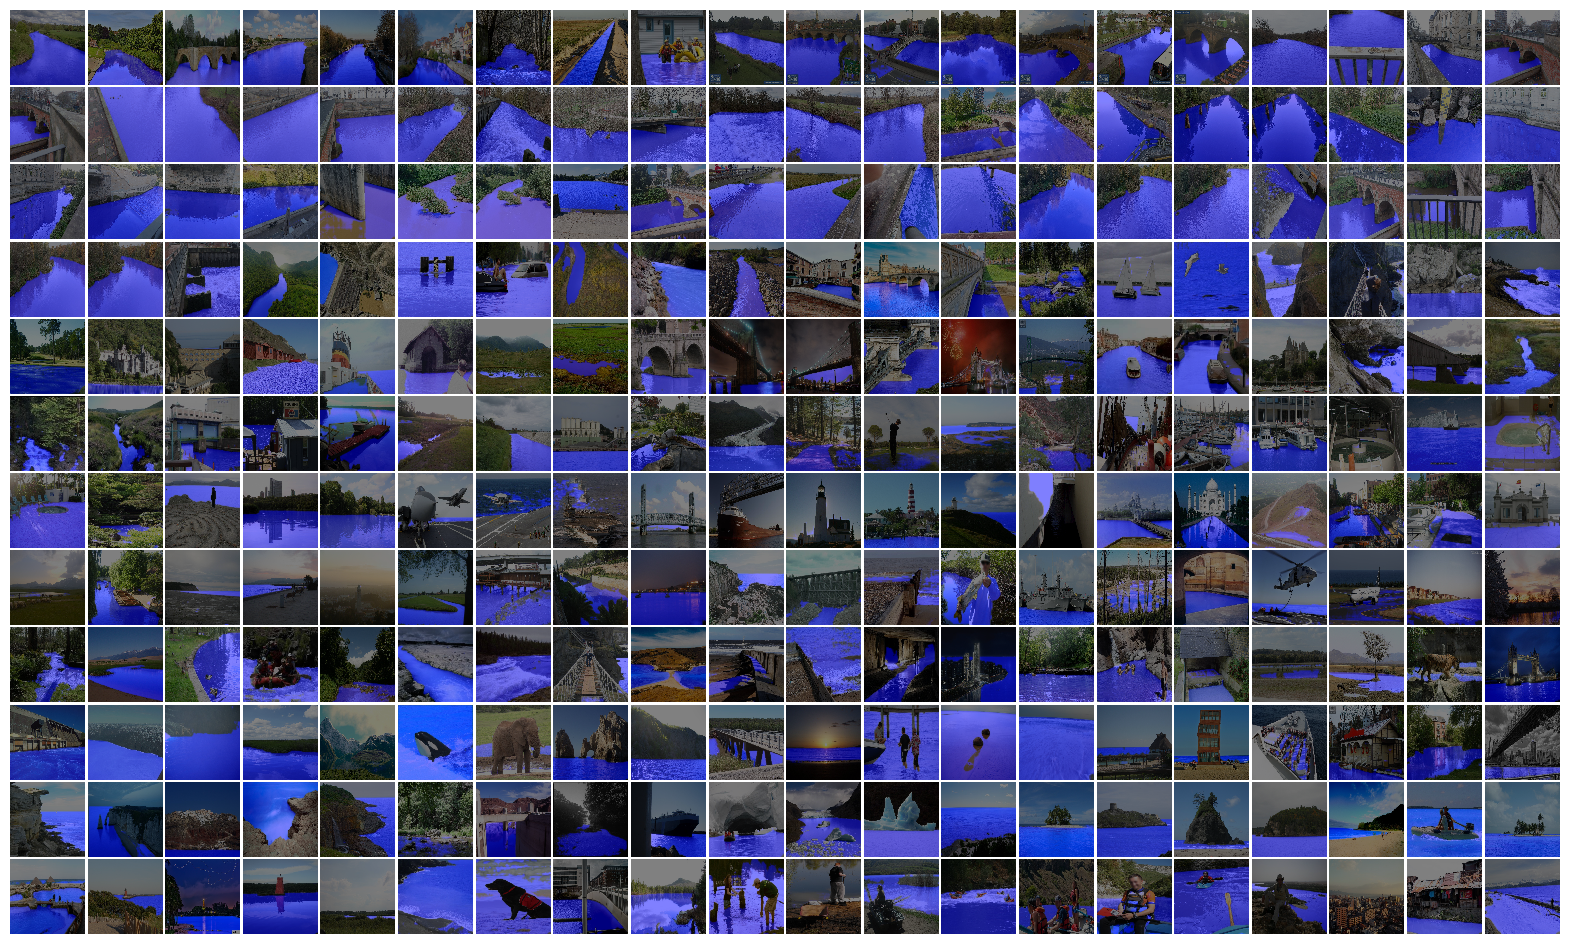

In [27]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

# Iterate over rows and columns
for i in range(12):
    for j in range(20):
        # Calculate the index for images_tuned_list and masks_binary_list
        index = i * 20 + j

        # Check if index is within the range of your data
        if index < len(images_tuned_list):
            # Display the RGB image
            axs[i, j].imshow(images_tuned_list[index], interpolation='none')

            # Create a blue mask with alpha channel
            blue_mask = np.zeros_like(masks_tuned_list[index])
            blue_mask[masks_tuned_list[index] == 1] = 1
            blue_mask_rgb = np.stack([np.zeros_like(blue_mask), np.zeros_like(blue_mask), blue_mask], axis=-1)
            # Overlay the blue mask on the RGB image
            axs[i, j].imshow(blue_mask_rgb, alpha=0.50)
            axs[i, j].axis('off')

# Reduce spacing between images
plt.subplots_adjust(wspace=0.03, hspace=0.03)

#Adjust layout to prevent clipping of subplot labels
#plt.tight_layout()
output_path = './241025_output_figure.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

### Evaluate

In [31]:
def binary_segmentation_metrics(predictions, targets):
    # Convert torch tensors to numpy arrays
    # Convert torch tensors to numpy arrays
    predictions = predictions.squeeze()
    targets = targets
    # Convert predictions to binary values (0 or 1)
    predictions_binary = (predictions > 0.5).astype(int)
    targets_binary = targets.astype(int)

    # Convert predictions to binary values (0 or 1)
    predictions_binary = (predictions > 0.5).astype(int)

    # True Positives (TP): prediction and target both are positive
    TP = np.sum((predictions_binary == 1) & (targets == 1))

    # False Positives (FP): prediction is positive but target is negative
    FP = np.sum((predictions_binary == 1) & (targets == 0))

    # False Negatives (FN): prediction is negative but target is positive
    FN = np.sum((predictions_binary == 0) & (targets == 1))

    # True Negatives (TN): prediction and target both are negative
    TN = np.sum((predictions_binary == 0) & (targets == 0))

    eps = 1e-5
    accuracy = (TP + TN + eps) / (TP + FP + FN + TN + eps)
    precision = (TP + eps) / (TP + FP + eps)
    recall = (TP + eps) / (TP + FN + eps)
    f_score = 2 * (precision * recall) / (precision + recall)
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    iou = (TP + eps) / (TP + FP + FN + eps)

    total = TP + FP + FN + TN
    p_o = (TP + TN) / total
    p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
    kappa = (p_o - p_e) / (1 - p_e)

    return accuracy, precision, recall, f_score, iou, kappa, FP, FN, TP, TN, dice

In [32]:
def calculate_average_metrics(predictions_list, targets_list):
    num_masks = len(predictions_list)

    total_metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f_score': 0.0,
        'iou': 0.0,
        'kappa': 0.0,
        'FP': 0,
        'FN': 0,
        'MAR': 0.0,
        'FAR': 0.0,
        'dice': 0.0
    }

    for i in range(num_masks):
        metrics = binary_segmentation_metrics(predictions_list[i], targets_list[i])

        for metric_name, value in zip(total_metrics.keys(), metrics):
            total_metrics[metric_name] += value

        total_metrics['MAR'] += metrics[8] / (metrics[8] + metrics[9])
        total_metrics['FAR'] += metrics[6] / (metrics[9] + metrics[6])

    avg_metrics = {k: v / num_masks for k, v in total_metrics.items()}

    return avg_metrics

In [33]:
avg_metrics = calculate_average_metrics(masks_tuned_list, 
                                        test_masks)


C:\Users\danusys16\AppData\Local\Temp\ipykernel_10772\1754083367.py:35: RuntimeWarning: overflow encountered in scalar multiply
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
C:\Users\danusys16\AppData\Local\Temp\ipykernel_10772\1754083367.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
C:\Users\danusys16\AppData\Local\Temp\ipykernel_10772\1754083367.py:36: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_o - p_e) / (1 - p_e)
C:\Users\danusys16\AppData\Local\Temp\ipykernel_10772\1754083367.py:35: RuntimeWarning: overflow encountered in scalar add
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)


In [34]:
for metric_name, value in avg_metrics.items():
    print(f"Average {metric_name}: {value}")

Average accuracy: 0.968901654682609
Average precision: 0.9628791606901839
Average recall: 0.9305802643596526
Average f_score: 0.943138217531358
Average iou: 0.9059535302085154
Average kappa: nan
Average FP: 2349.463519313305
Average FN: 5802.781115879829
Average MAR: 99219.07178479698
Average FAR: 154773.08541514963
Average dice: 0.9431382175259826
